In [1]:
import pandas as pd
import numpy as np

In [2]:
mv = pd.read_csv('/Users/yuanxiaoyang/Desktop/绰睿笔试/Shareholder Value Market Value.csv', index_col=0)
mv = mv.set_index(["S_INFO_WINDCODE", "TRADE_DT"]).unstack(0)
mv.columns = mv.columns.droplevel(0)

mask_big_mv =  mv.gt(mv.median(1), axis=0)
mask_small_mv = mv.lt(mv.median(1), axis=0)

In [3]:
tt = pd.read_csv('/Users/yuanxiaoyang/Desktop/绰睿笔试/TOT_ASSETS.csv', index_col=0)
tt = (tt.groupby(["S_INFO_WINDCODE", "TRADE_DT"]).sum()).unstack(0).ffill()
tt.columns = tt.columns.droplevel(0)

lb = pd.read_csv('/Users/yuanxiaoyang/Desktop/绰睿笔试/TOT_LIAB.csv', index_col=0)
lb = (lb.groupby(["S_INFO_WINDCODE", "TRADE_DT"]).sum()).unstack(0).ffill()
lb.columns = lb.columns.droplevel(0)
    
bm = (tt - lb)/mv

mask_high_bm = bm.gt(bm.median(1), axis=0)
mask_low_bm = bm.lt(bm.median(1), axis=0)

In [4]:
close = pd.read_csv("/Users/yuanxiaoyang/Desktop/绰睿笔试/CLOSE.csv", index_col=0)
close = close.set_index(["S_INFO_WINDCODE", "TRADE_DT"]).unstack(0)
close.columns = close.columns.droplevel(0)

In [5]:
ret = close.pct_change().shift(-1)

m_ret = ret.mean(axis=1)
mv_ret = ret[mask_big_mv].mean(1) - ret[mask_small_mv].mean(1)
bm_ret = ret[mask_high_bm].mean(1) - ret[mask_low_bm].mean(1)

In [6]:

from sklearn.linear_model import LinearRegression

def linear_regression_residuals(x, y):
    x = np.nan_to_num(x)
    y = np.nan_to_num(y)
    if x.ndim == 1:
        x = x.reshape(-1, 1)

    model = LinearRegression()
    model.fit(x, y)

    y_pred = model.predict(x)

    residuals = y - y_pred

    return residuals

In [7]:
from tqdm import tqdm
factors = pd.concat([m_ret, mv_ret, bm_ret], axis=1)
factors.columns = ["RMRF", "SMB", "HML"]
factors.index = pd.to_datetime(factors.index.astype(str))
ret.index = pd.to_datetime(ret.index.astype(str))
t_res = []
for (mn, mn_df), (mn, mn_ret) in tqdm(zip(factors.groupby(factors.index.month), ret.groupby(ret.index.month))):
    code_res = []
    for ret_code in ret.columns:
        y = mn_ret[ret_code].values
        res = linear_regression_residuals(mn_df.values, y)
        code_res.append(res)
    code_res = np.vstack(code_res)
    t_res.append(code_res)
final_res = np.hstack(t_res)
resudial = pd.DataFrame(final_res.T, index=factors.index, columns=ret.columns)

resudial_m = resudial.resample("1M").mean()
rolling_mean = resudial_m.shift(1).rolling(6).mean()
ffm_moment = resudial_m.shift(1).rolling(6).sum() / np.sqrt((resudial_m - rolling_mean).rolling(6).sum()**2)
fft_moment_d = ffm_moment.resample("D").ffill()
fft_moment_d = fft_moment_d["20210901":"20230901"].dropna(how="all")
ret_ = ret.reindex(index=fft_moment_d.index, columns=fft_moment_d.columns)

12it [00:17,  1.46s/it]


2024-04-09 17:04:29.858 | INFO     | bk_test:run_backtest:25 - Calculate long-short return
2024-04-09 17:04:29.960 | INFO     | bk_test:run_backtest:27 - Calculate grouped return
/Users/yuanxiaoyang/Desktop/绰睿笔试/bk_test.py:49: RuntimeWarning: Mean of empty slice
  bench_return = np.nanmean(cross_return, 1) if univ is None else np.nanmean(cross_return[univ], 1)
2024-04-09 17:04:30.505 | INFO     | bk_test:run_backtest:29 - Calculate IC
2024-04-09 17:04:31.292 | INFO     | bk_test:run_backtest:31 - Calculate metrics
2024-04-09 17:04:31.352 | INFO     | bk_test:run_backtest:33 - Plot long-short return


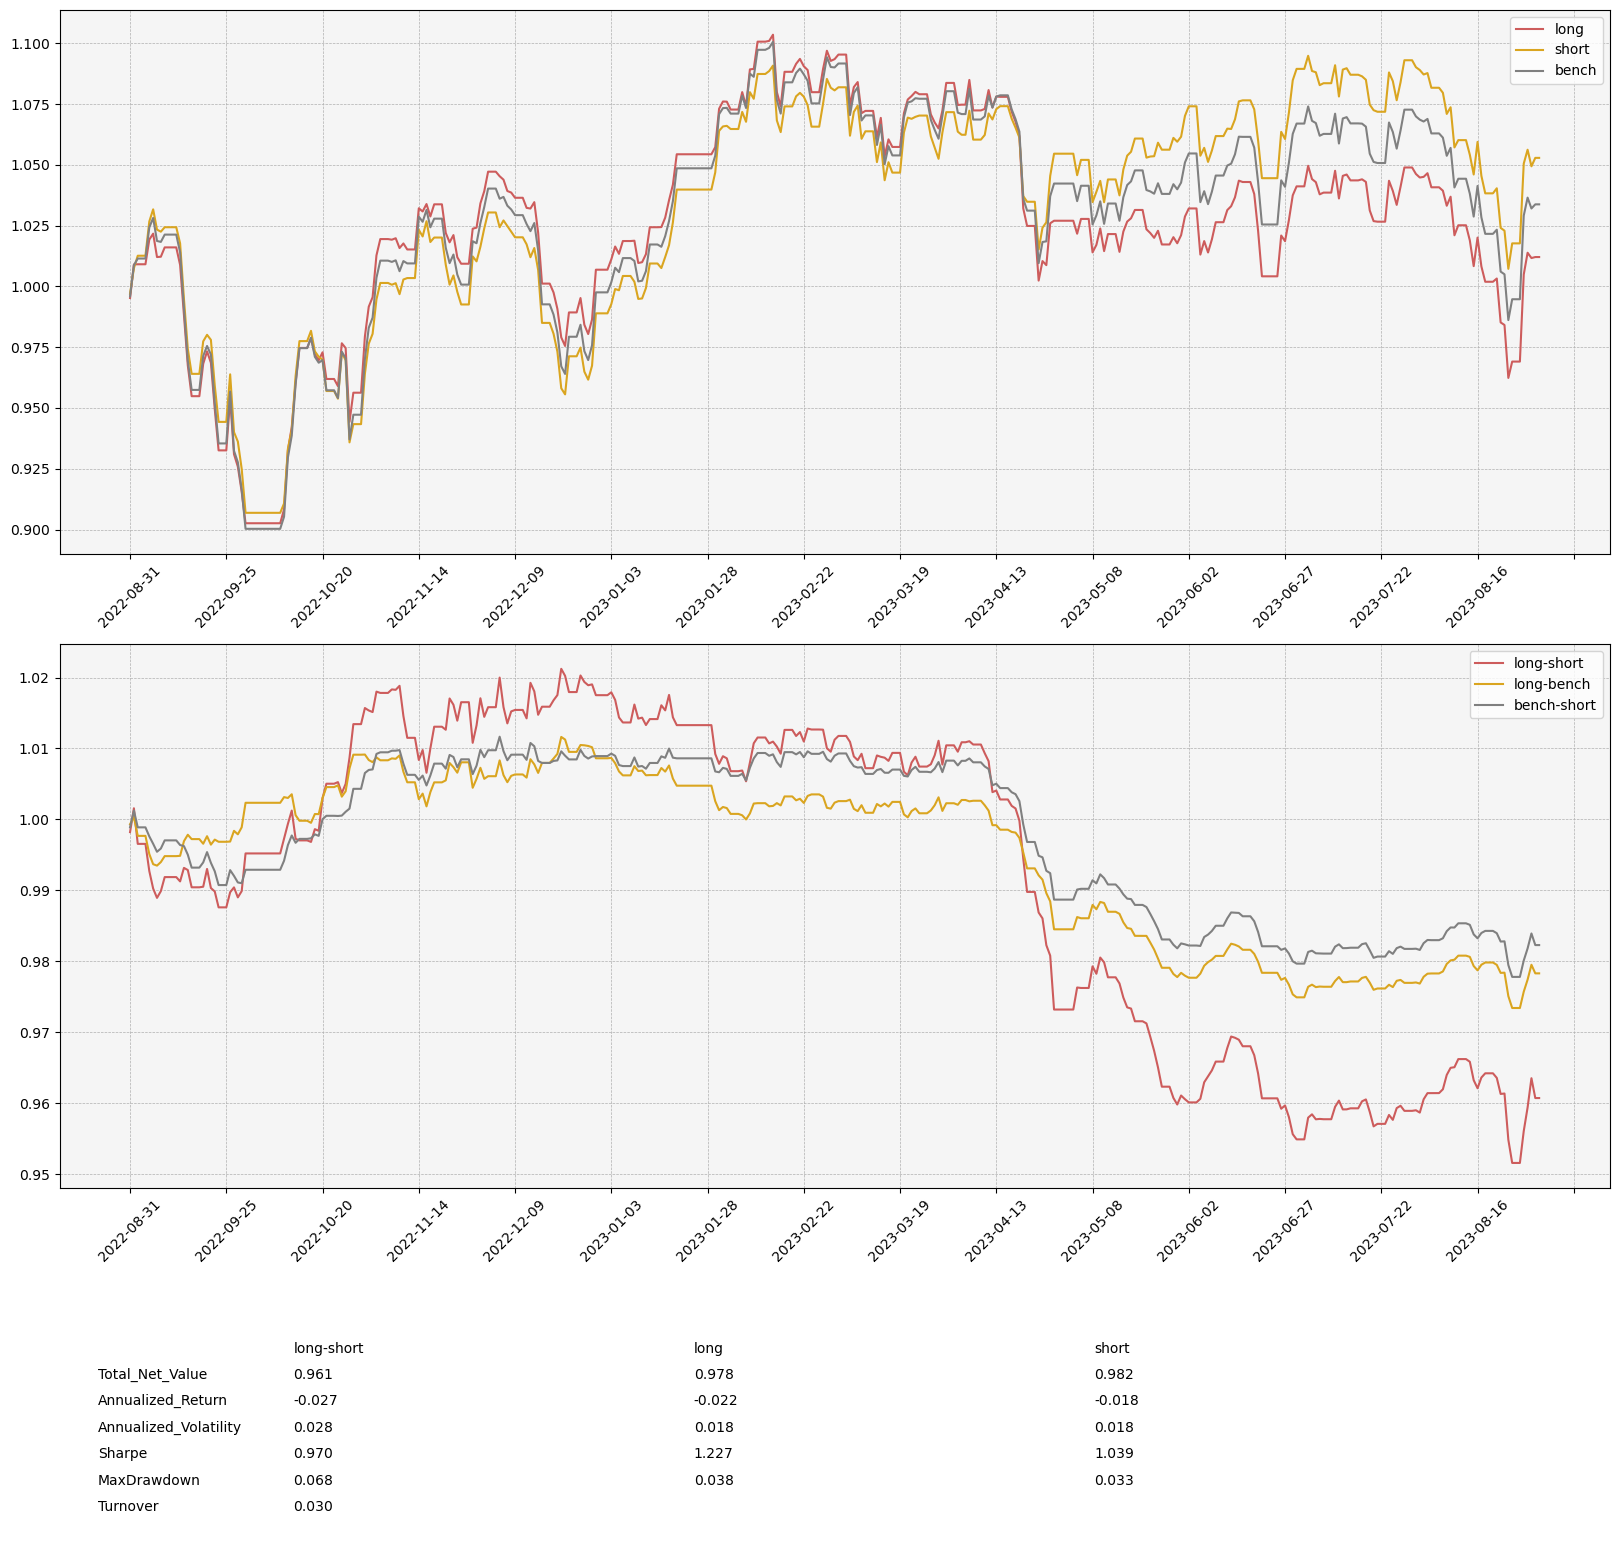

2024-04-09 17:04:32.063 | INFO     | bk_test:run_backtest:35 - Plot IC


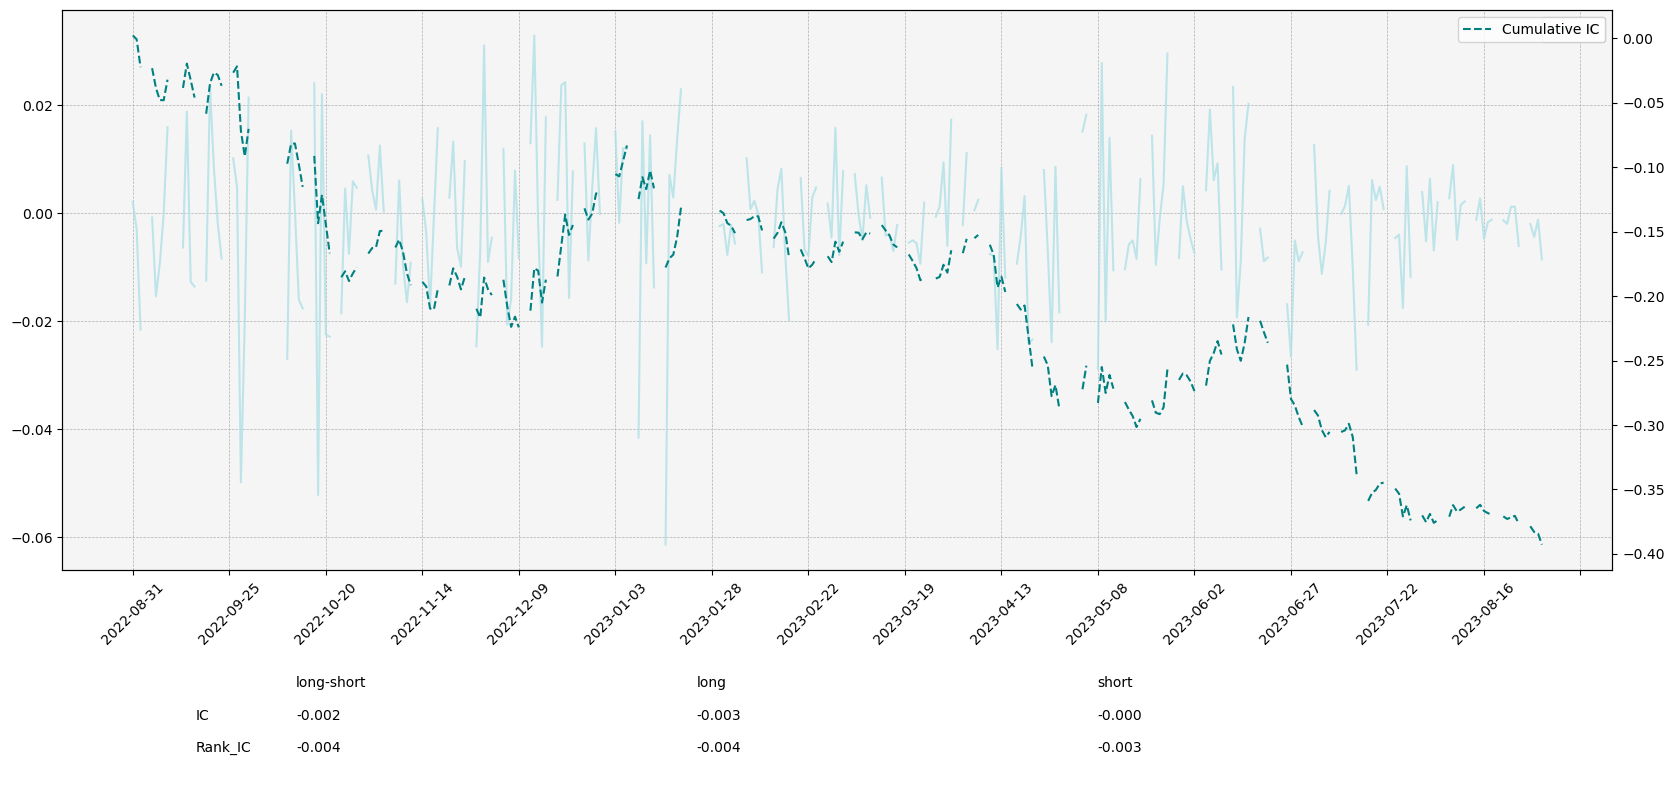

2024-04-09 17:04:32.453 | INFO     | bk_test:run_backtest:37 - Plot grouped return


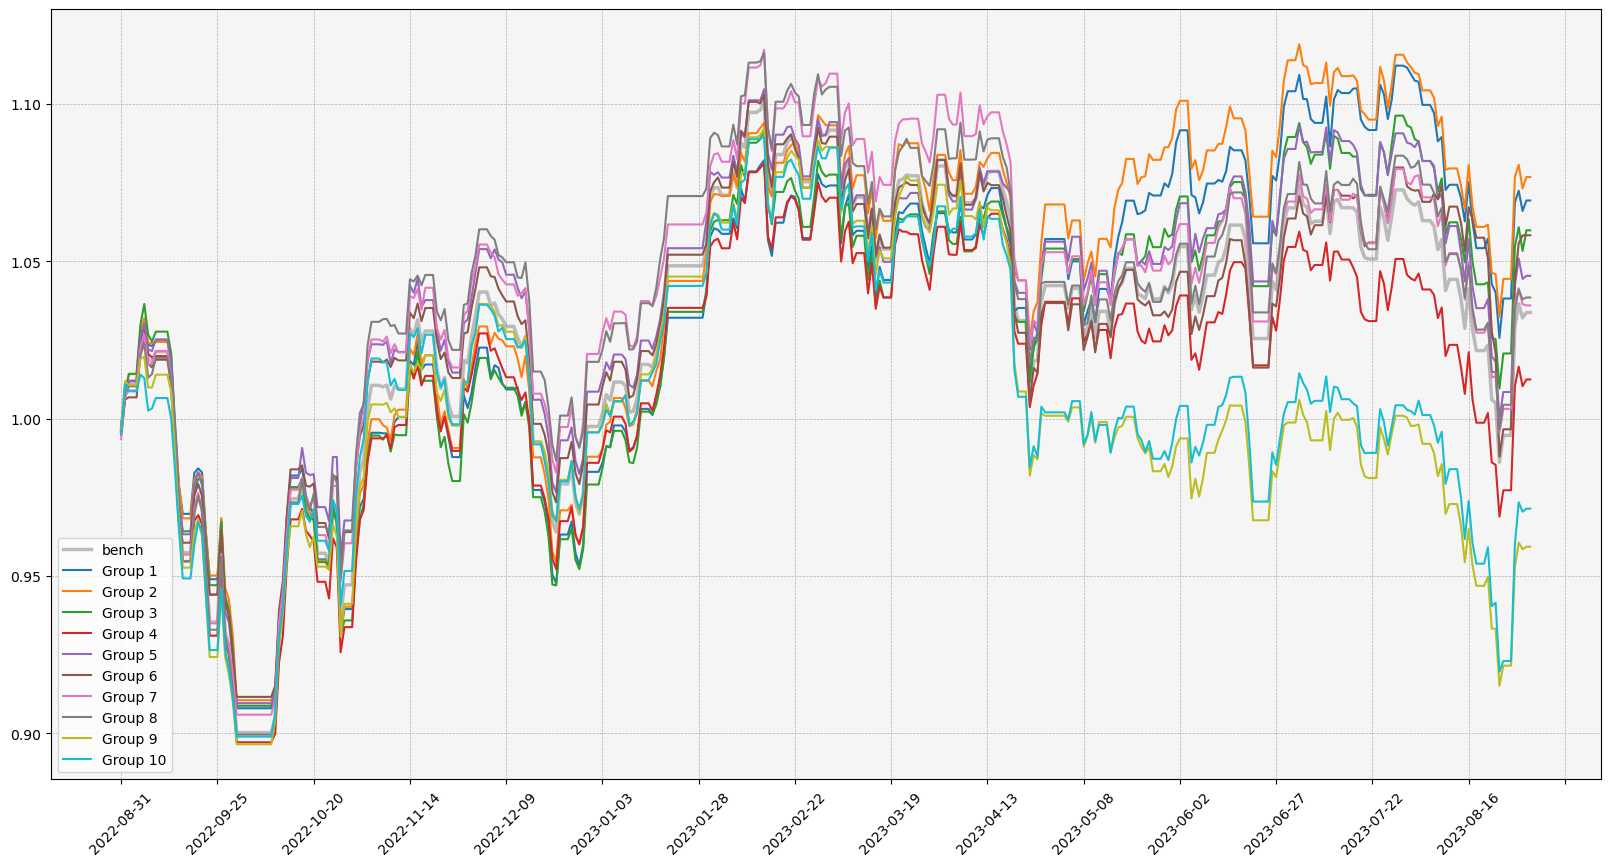

In [12]:
import os
import sys
curPath = os.path.abspath(os.path.dirname('/Users/yuanxiaoyang/Desktop/绰睿笔试/bk_test.py'))
sys.path.append(curPath)
from bk_test import BKInterface
bkm = BKInterface(ret_)
bkm.run_backtest(fft_moment_d)

2024-04-09 17:05:10.483 | INFO     | bk_test:run_backtest:25 - Calculate long-short return
2024-04-09 17:05:10.519 | INFO     | bk_test:run_backtest:27 - Calculate grouped return
2024-04-09 17:05:10.679 | INFO     | bk_test:run_backtest:29 - Calculate IC
2024-04-09 17:05:11.064 | INFO     | bk_test:run_backtest:31 - Calculate metrics
2024-04-09 17:05:11.088 | INFO     | bk_test:run_backtest:33 - Plot long-short return


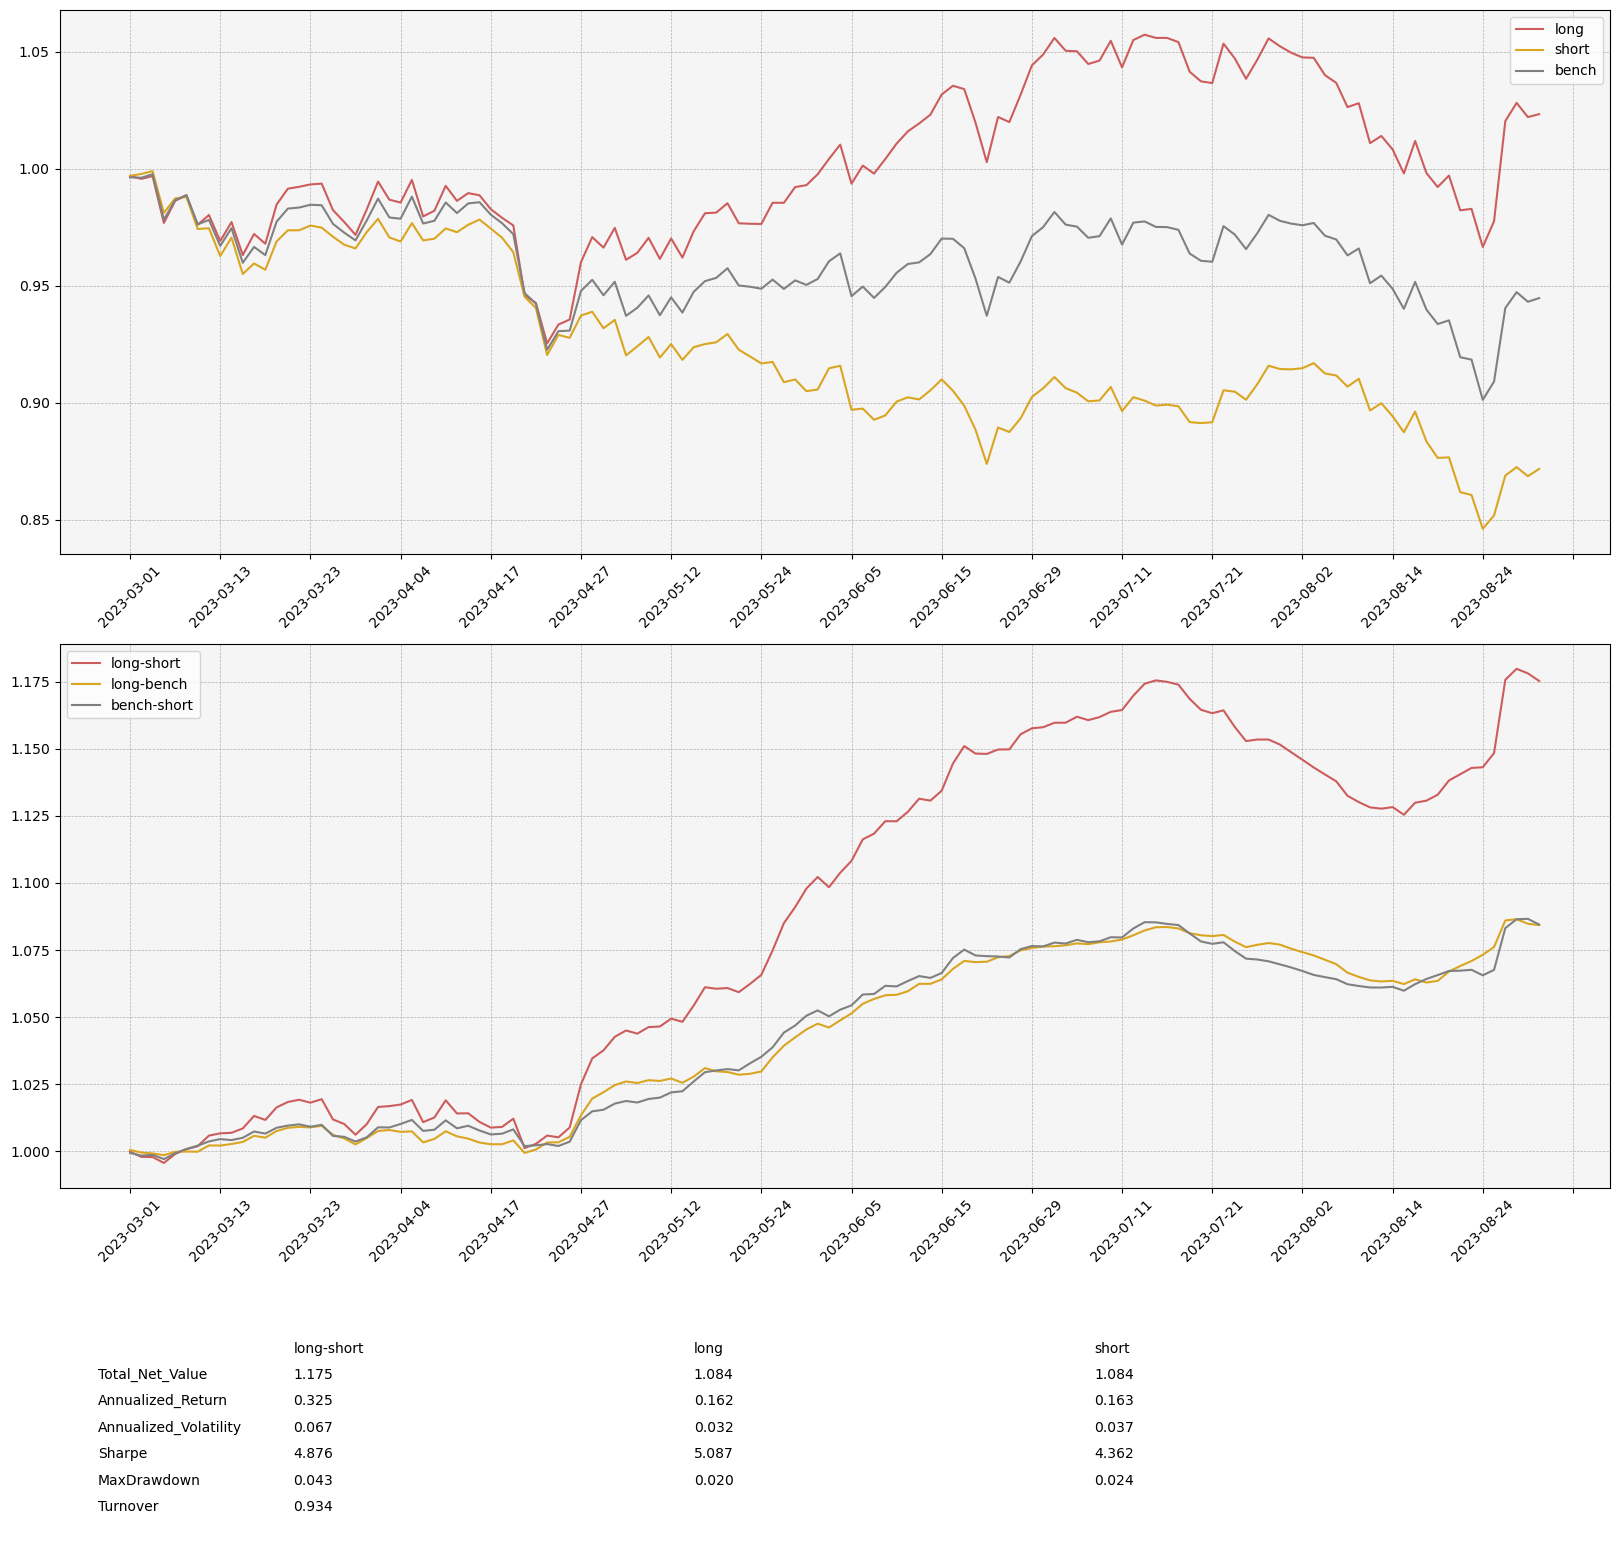

2024-04-09 17:05:11.478 | INFO     | bk_test:run_backtest:35 - Plot IC


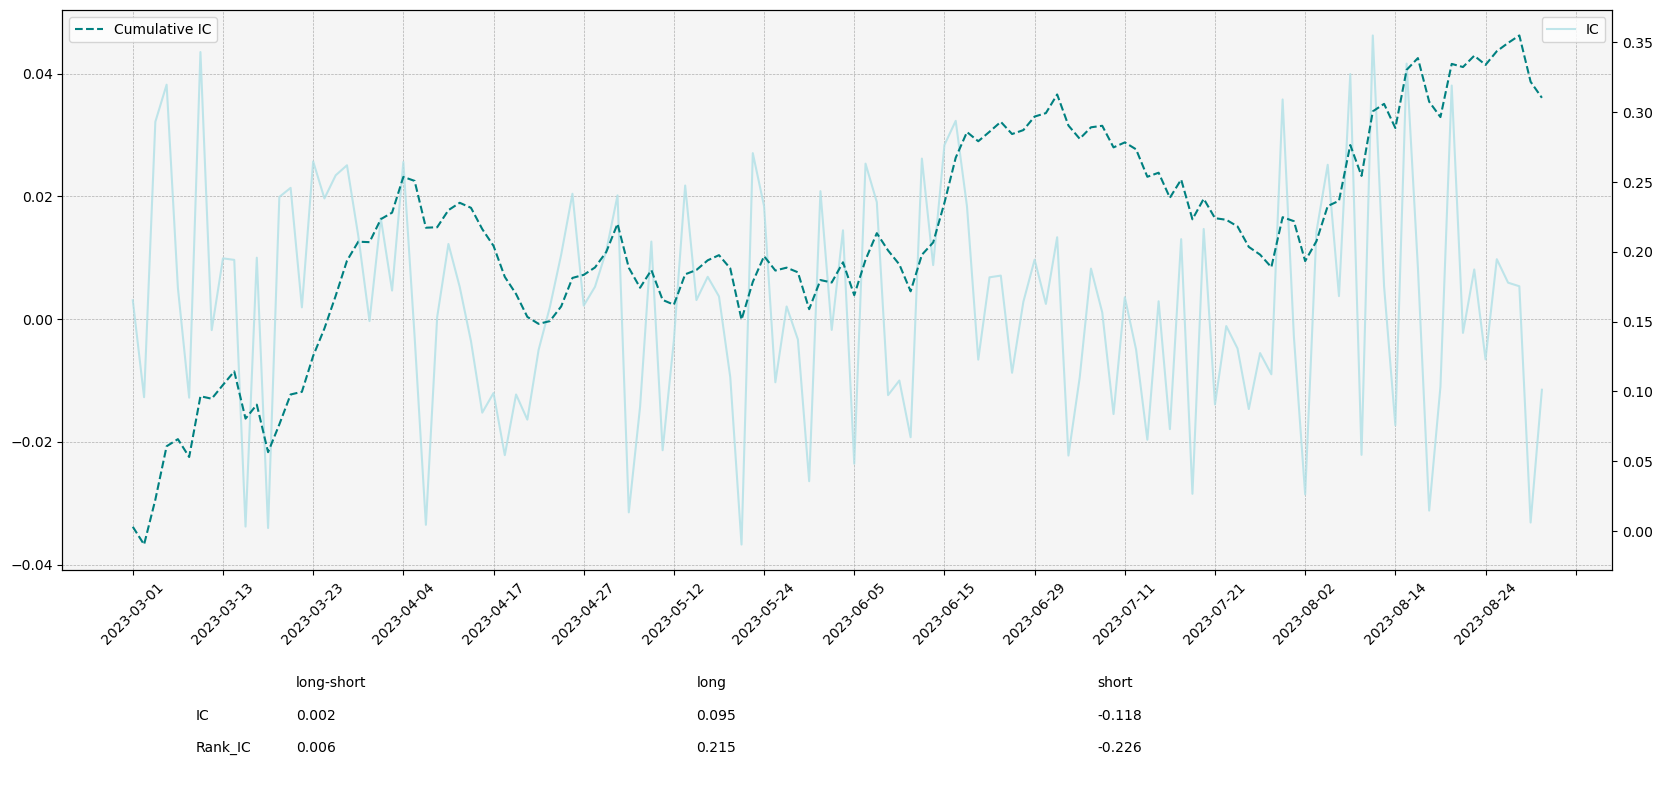

2024-04-09 17:05:11.710 | INFO     | bk_test:run_backtest:37 - Plot grouped return


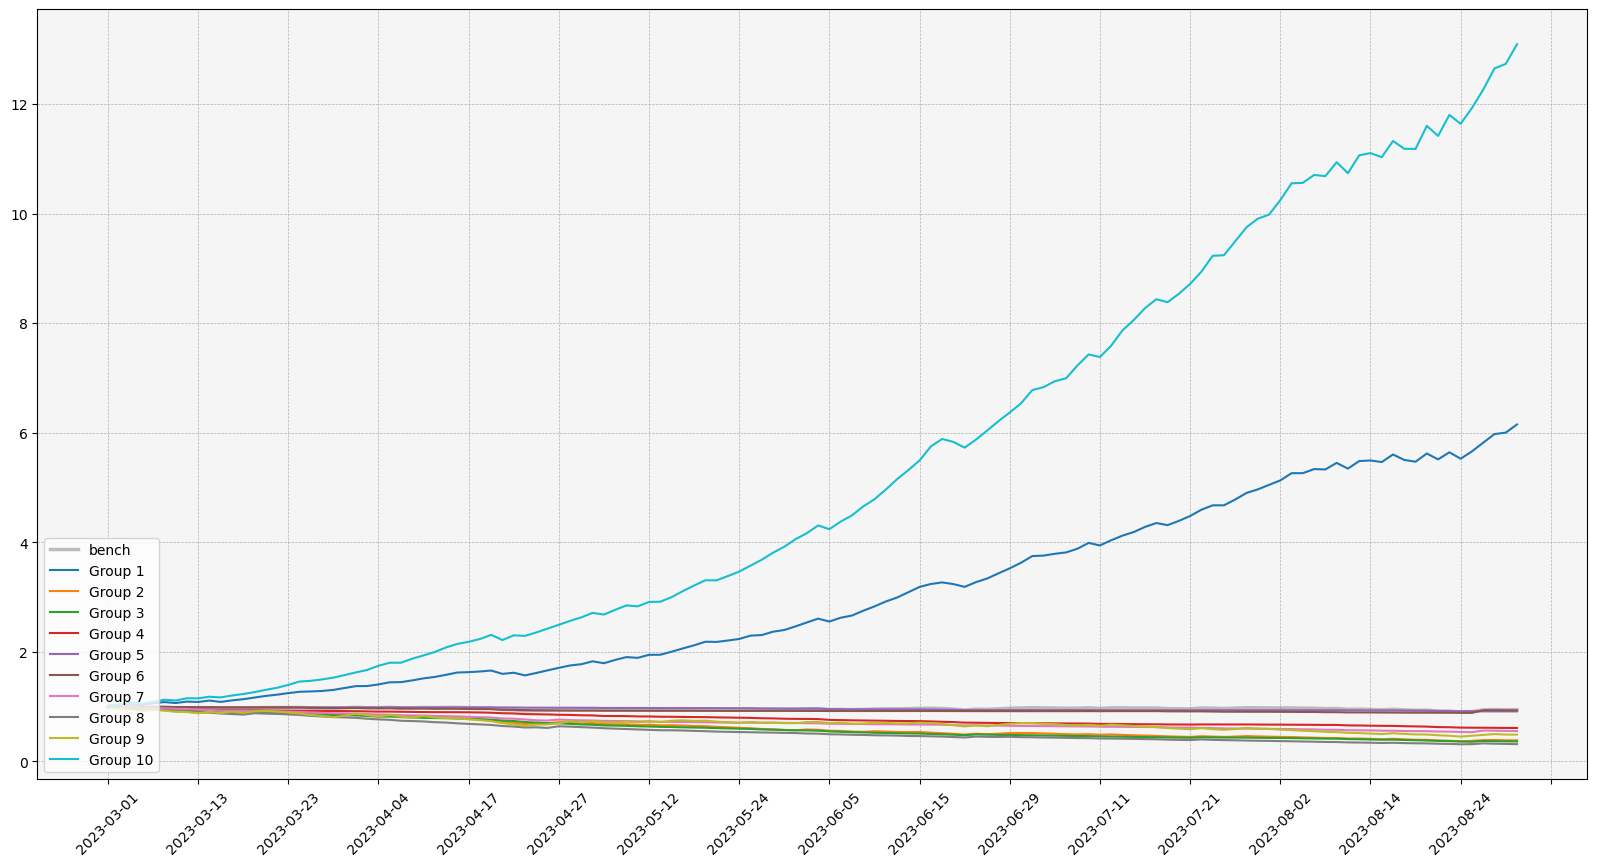

In [13]:
tsmom = (ret - ret.ewm(span=12*30).mean()).rolling(12*30).mean().apply(lambda x: np.sign(x))*(ret - ret.ewm(span=12*30).mean())/(ret - ret.ewm(span=12*30).std())
tsmom = tsmom["20210901":"20230901"].dropna(how="all")
ret_ = ret.reindex(index=tsmom.index, columns=tsmom.columns)
from bk_test import BKInterface
bkm = BKInterface(ret_)
bkm.run_backtest(tsmom)